# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import datetime
import colorama
from colorama import Fore, Back, Style

sns.set_style("whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


from IPython.display import Markdown
colorama.init(autoreset=True)

def bold(string):
    display(Markdown(string))

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Load Data

In [2]:
df = pd.read_csv("/mnt/hdd/Datasets/MarathonData.csv")

In [3]:
def df_stats(data):
    print(" SHAPE ".center(50, "#"))
    print("ROWS: {}".format(data.shape[0]))
    print("COLUMNS: {}".format(data.shape[0]))
    print(" TYPES ".center(50, "#"))
    print(data.dtypes)
    print(" MISSING VALUES ".center(50, "#"))
    print(data.isnull().sum())
    print(" DUPLICATED VALUES ".center(50, "#"))
    print("NUMBER OF DUPLICATED VALUES: {}".format(data.duplicated().sum()))
    print(" DESCRIBE ".center(50, "#"))
    print(data.describe().T)

In [4]:
df_stats(df)

##################### SHAPE ######################
ROWS: 87
COLUMNS: 87
##################### TYPES ######################
id                 int64
Marathon          object
Name              object
Category          object
km4week          float64
sp4week          float64
CrossTraining     object
Wall21            object
MarathonTime     float64
CATEGORY          object
dtype: object
################# MISSING VALUES #################
id                0
Marathon          0
Name              0
Category          6
km4week           0
sp4week           0
CrossTraining    74
Wall21            0
MarathonTime      0
CATEGORY          0
dtype: int64
############### DUPLICATED VALUES ################
NUMBER OF DUPLICATED VALUES: 0
#################### DESCRIBE ####################
              count   mean     std   min   25%   50%   75%      max
id            87.00  44.00   25.26  1.00 22.50 44.00 65.50    87.00
km4week       87.00  62.35   26.96 17.90 44.20 58.80 77.50   137.50
sp4week     

# Handling Missing Values

In [5]:
df.head()

,id,Marathon,Name,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime,CATEGORY
0,1,Prague17,Blair MORGAN,MAM,132.80,14.43,NaN,1.16,2.37,A
1,2,Prague17,Robert Heczko,MAM,68.60,13.67,NaN,1.23,2.59,A
2,3,Prague17,Michon Jerome,MAM,82.70,13.52,NaN,1.30,2.66,A
3,4,Prague17,Daniel Or lek,M45,137.50,12.26,NaN,1.32,2.68,A
4,5,Prague17,Luk ? Mr zek,MAM,84.60,13.95,NaN,1.36,2.74,A


In [6]:
df.isnull().sum()

id                0
Marathon          0
Name              0
Category          6
km4week           0
sp4week           0
CrossTraining    74
Wall21            0
MarathonTime      0
CATEGORY          0
dtype: int64

In [7]:
df["CrossTraining"].unique()

array([nan, 'ciclista 1h', 'ciclista 4h', 'ciclista 13h', 'ciclista 5h',
       'ciclista 3h'], dtype=object)

In [8]:
df["CrossTraining"].fillna("nonct", inplace=True)

In [9]:
df["Category"].unique()

array(['MAM', 'M45', 'M40', 'M50', 'M55', nan, 'WAM'], dtype=object)

In [10]:
df.dropna(how="any", inplace=True)

# EDA

In [11]:
df.drop(columns=["id", "Name", "CATEGORY"], inplace=True)

In [12]:
df["Wall21"] = df["Wall21"].astype("float")

In [13]:
df.head()

,Marathon,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,Prague17,MAM,132.80,14.43,nonct,1.16,2.37
1,Prague17,MAM,68.60,13.67,nonct,1.23,2.59
2,Prague17,MAM,82.70,13.52,nonct,1.30,2.66
3,Prague17,M45,137.50,12.26,nonct,1.32,2.68
4,Prague17,MAM,84.60,13.95,nonct,1.36,2.74


In [14]:
target = "MarathonTime"
numerical_variables = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col]) and col != target]
categorical_variables = [col for col in df.columns if pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == "object"]

In [15]:
bold("**Numerical Variables**")
print(numerical_variables)

**Numerical Variables**

['km4week', 'sp4week', 'Wall21']


In [16]:
bold("**Categorical Variables")
print(categorical_variables)

**Categorical Variables

['Marathon', 'Category', 'CrossTraining']


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81 entries, 0 to 86
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Marathon       81 non-null     object 
 1   Category       81 non-null     object 
 2   km4week        81 non-null     float64
 3   sp4week        81 non-null     float64
 4   CrossTraining  81 non-null     object 
 5   Wall21         81 non-null     float64
 6   MarathonTime   81 non-null     float64
dtypes: float64(4), object(3)
memory usage: 5.1+ KB


In [18]:
def plot_count(df, col, title):
    fig, ax = plt.subplots(1 ,2, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.2)

    values = df[col].value_counts()
    N = len(values)

    outer_pie = values
    inner_pie = values / N

    ax[0].pie(
        outer_pie,
        labels=values.index.tolist(),
        startangle=90,
        frame=False,
        radius=1.3,
        explode=([0.05] * (N-1) + [0.3]),
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        textprops={"fontsize": 12, "weight": "bold"}
    )

    ax[0].pie(
        inner_pie,
        radius=1,
        startangle=90,
        autopct="%1.f%%",
        explode=([0.1] * (N-1) + [0.3]),
        pctdistance=0.8,
        textprops={"size": 13, "weight": "bold", "color": "white"}
    )

    center_circle = plt.Circle((0, 0), 0.7, color="black", fc="white", linewidth=0)
    ax[0].add_artist(center_circle)

    sns.barplot(x=values, y=values.index.tolist(), orient="horizontal")

    for i, v in enumerate(values):
        ax[1].text(v, i+0.1, str(v), color="black", fontweight="bold", fontsize=13)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color="black")
    ax[1].set_ylabel("count", fontweight="bold", color="black")

    fig.suptitle(f"{title}", fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()

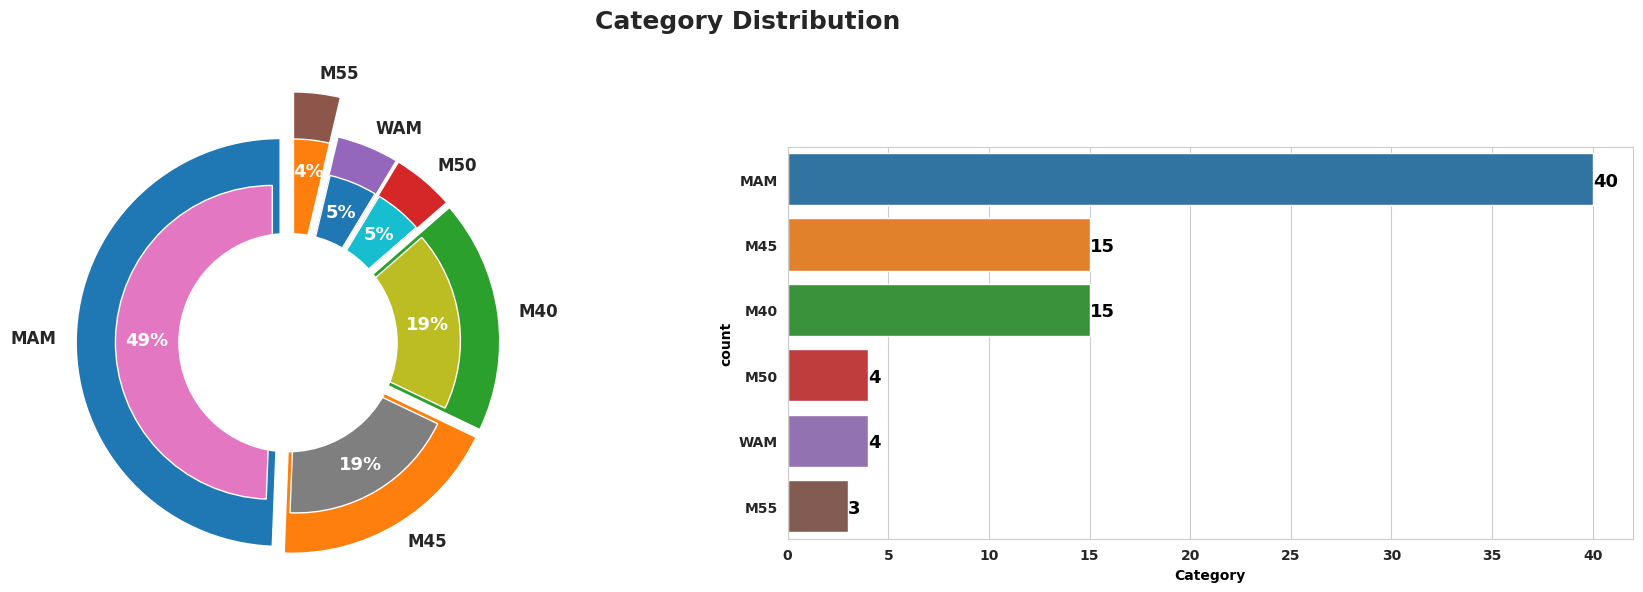

In [19]:
plot_count(df, "Category", "Category Distribution")

In [20]:
def plot_category_time(data, x, y):
    f, ax = plt.subplots(figsize=(15, 5))
    sns.swarmplot(data=data, x=x, y=y, ax=ax)
    plt.title("Marathon / Time")
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

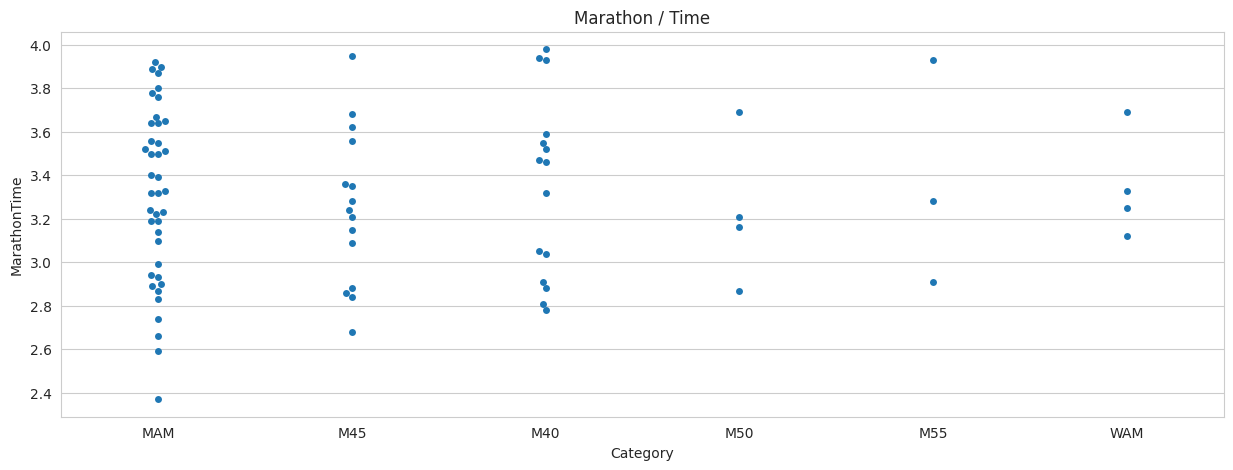

In [21]:
plot_category_time(df, "Category", "MarathonTime")

In [22]:
def plot_num(df, columns):
    for i, column in enumerate(columns):
        plt.subplot(int(len(columns) / 2) + 1, 2, i + 1)
        sns.histplot(x=column, data=df, bins=30, kde=True)
        plt.axvline(df[column].mean(), color="r", linestyle="--", label="Mean")
        plt.axvline(df[column].median(), color="g", linestyle="-", label="Median")
        plt.grid()
        plt.title(f"{column} Distribution")
        plt.tight_layout()

    plt.show()

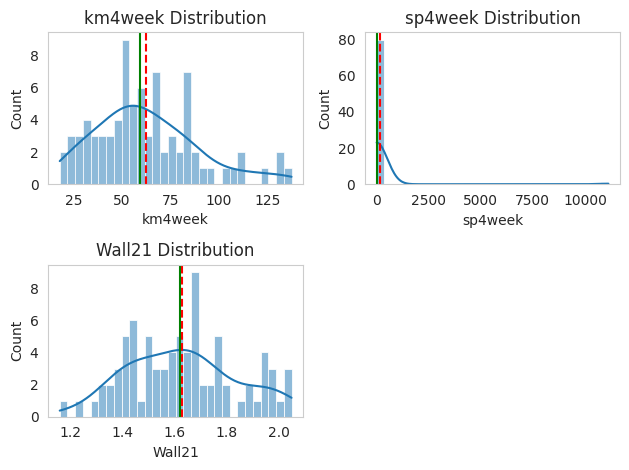

In [23]:
plot_num(df, numerical_variables)

# Outlier Detection

In [24]:
def custom_boxplot(df, columns, title):
    fig, ax = plt.subplots(int(len(columns) / 2)+1, 2, sharey=True, figsize=(15, len(columns) * 2.5))
    fig.suptitle(title, y=1, size=25)
    ax = ax.flatten()
    for i, column in enumerate(columns):
        sns.boxplot(data=df[column], orient="h", ax=ax[i])
        ax[i].set_title(column + ", skewness is: " + str(round(df[column].skew(axis=0, skipna=True), 2)))

    plt.tight_layout()
    plt.show()

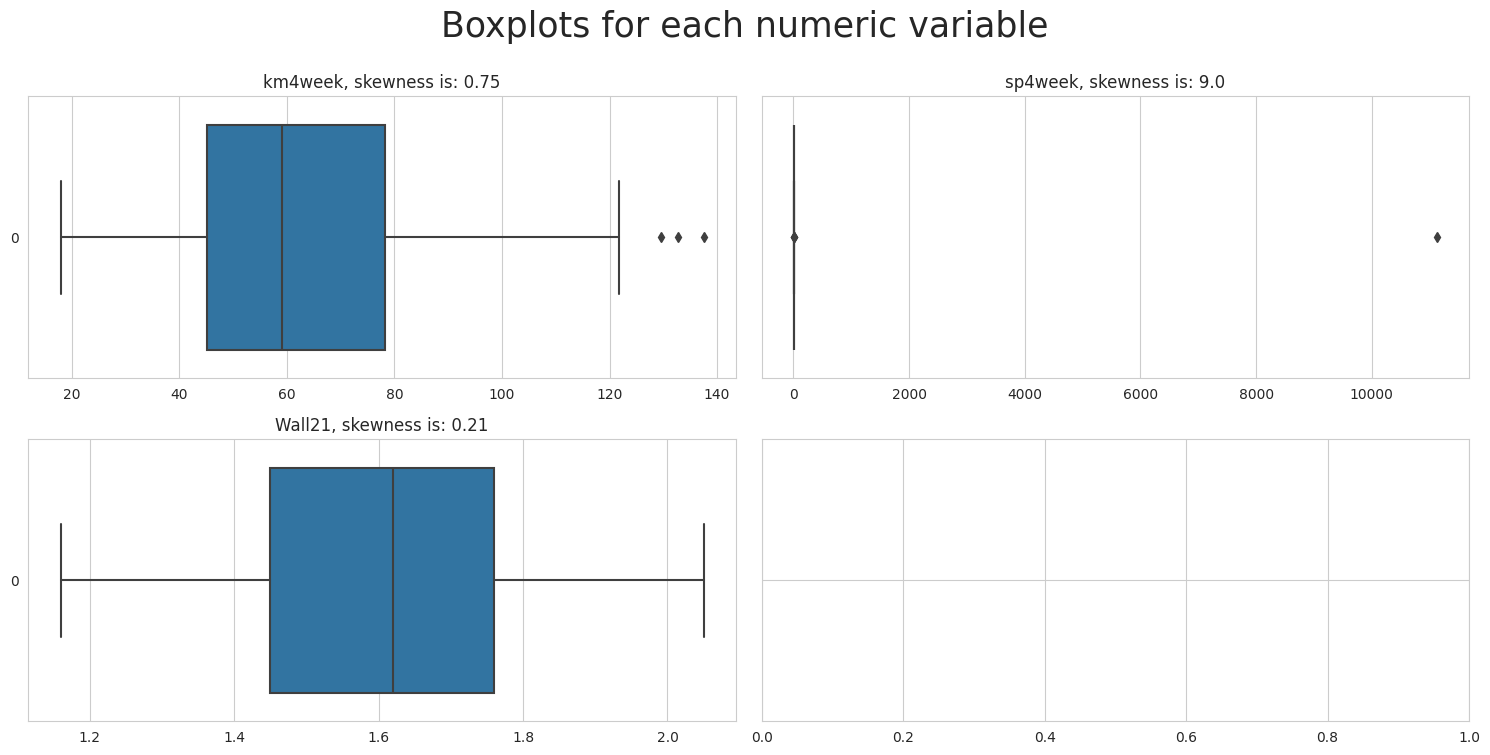

In [25]:
custom_boxplot(df, numerical_variables, "Boxplots for each numeric variable")

In [26]:
df = df[(df["km4week"] < 120) & (df["sp4week"] < 14) & (df["sp4week"] > 10)].reset_index(drop=True)

In [27]:
df.shape

(71, 7)

# Feature Scaling

In [28]:
df.head()

,Marathon,Category,km4week,sp4week,CrossTraining,Wall21,MarathonTime
0,Prague17,MAM,68.60,13.67,nonct,1.23,2.59
1,Prague17,MAM,82.70,13.52,nonct,1.30,2.66
2,Prague17,MAM,84.60,13.95,nonct,1.36,2.74
3,Prague17,M40,42.20,13.61,nonct,1.32,2.78
4,Prague17,M40,89.00,12.59,nonct,1.38,2.81


In [29]:
def list_uniq(df, columns):
    for column in columns:
        print(f" {column} ".center(30, "#"))
        for i, val in enumerate(df[column].unique()):
            print(f"{i+1}. {val}")
        print()

In [30]:
list_uniq(df, categorical_variables)

########## Marathon ##########
1. Prague17

########## Category ##########
1. MAM
2. M40
3. M45
4. M50
5. M55
6. WAM

####### CrossTraining ########
1. nonct
2. ciclista 1h
3. ciclista 13h
4. ciclista 3h
5. ciclista 5h
6. ciclista 4h



In [31]:
df.drop(columns=["Marathon", "Category"], inplace=True)

In [32]:
df = pd.get_dummies(df, dtype=int)

In [33]:
df.head()

,km4week,sp4week,Wall21,MarathonTime,CrossTraining_ciclista 13h,CrossTraining_ciclista 1h,CrossTraining_ciclista 3h,CrossTraining_ciclista 4h,CrossTraining_ciclista 5h,CrossTraining_nonct
0,68.60,13.67,1.23,2.59,0,0,0,0,0,1
1,82.70,13.52,1.30,2.66,0,0,0,0,0,1
2,84.60,13.95,1.36,2.74,0,0,0,0,0,1
3,42.20,13.61,1.32,2.78,0,0,0,0,0,1
4,89.00,12.59,1.38,2.81,0,0,0,0,0,1


In [34]:
df.corr().abs()["MarathonTime"].sort_values(ascending=False)

MarathonTime                 1.00
Wall21                       0.96
sp4week                      0.75
km4week                      0.63
CrossTraining_ciclista 5h    0.21
CrossTraining_ciclista 1h    0.17
CrossTraining_ciclista 3h    0.17
CrossTraining_nonct          0.17
CrossTraining_ciclista 4h    0.15
CrossTraining_ciclista 13h   0.14
Name: MarathonTime, dtype: float64

In [35]:
X = df[["Wall21", "sp4week", "km4week", "CrossTraining_ciclista 5h"]]
y = df["MarathonTime"]

In [36]:
#transformer = ColumnTransformer(transformers=[
#    ("tnf1", OneHotEncoder(sparse=False, drop="first"), ["Category", "CrossTraining"])
#])

#X_scaled = transformer.fit_transform(X)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [38]:
X_train.shape

(35, 4)

In [39]:
def adjusted_r2(r2, n, k):
    return r2 - (k - 1) / (n - k) * (1 - r2)

In [40]:
def root_mse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

# Model Training

In [41]:
kf = KFold(n_splits=5, shuffle=False)

In [42]:
scores_df = pd.DataFrame({
    "Model": [],
    "R2": [],
    "Adjusted R2": [],
    "MSE": [],
    "RMSE": [],
    "MAE": []
})

In [62]:
def cross_validation(model):
    model_log = pd.DataFrame(columns=["R2", "Adjusted R2", "MSE", "RMSE", "MAE"])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    model_log.loc[0, "R2"] = r2_score(y_test, y_pred)
    model_log.loc[0, "Adjusted R2"] = adjusted_r2(r2_score(y_test, y_pred), X.shape[0], X.shape[1])
    model_log.loc[0, "MSE"] = mean_squared_error(y_test, y_pred)
    model_log.loc[0, "RMSE"] = root_mse(y_test, y_pred)
    model_log.loc[0, "MAE"] = mean_absolute_error(y_test, y_pred)

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.regplot(x=y_test, y=y_pred)
    plt.show()
    
    return model_log

In [63]:
scores_df

,Model,R2,Adjusted R2,MSE,RMSE,MAE
0,LinearRegression,0.91,0.91,0.01,0.10,0.08
1,Ridge,0.80,0.79,0.02,0.14,0.11
2,Lasso,0.35,0.33,0.07,0.26,0.21
3,ElasticNet,0.32,0.29,0.07,0.27,0.21
4,KernelRidge,0.80,0.79,0.02,0.14,0.12
5,SVR,0.31,0.28,0.07,0.27,0.21
6,RandomForestRegressor,0.85,0.84,0.02,0.12,0.10
7,GradientBoostingRegressor,0.86,0.86,0.01,0.12,0.09
8,AdaBoostRegressor,0.87,0.87,0.01,0.12,0.09
9,XGBRegressor,0.84,0.84,0.02,0.13,0.10


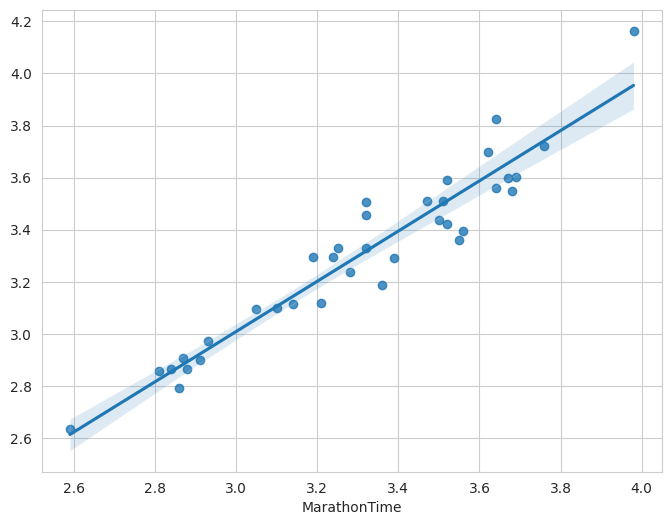

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.91,0.91,0.01,0.10,0.08


In [64]:
linreg = LinearRegression()
linreg_log = cross_validation(linreg)
scores_df.loc[0] = ["LinearRegression", linreg_log["R2"].mean(), linreg_log["Adjusted R2"].mean(), 
                linreg_log["MSE"].mean(), linreg_log["RMSE"].mean(), linreg_log["MAE"].mean()]
linreg_log

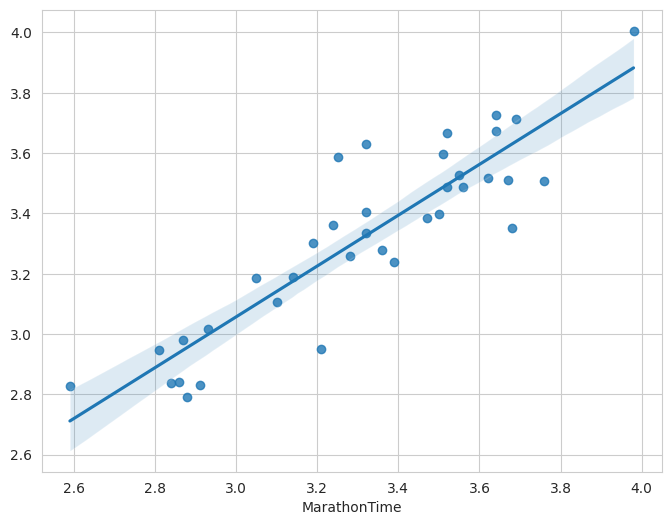

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.80,0.79,0.02,0.14,0.11


In [67]:
ridge = Ridge()
ridge_log = cross_validation(ridge)
scores_df.loc[1] = ["Ridge", ridge_log["R2"].mean(), ridge_log["Adjusted R2"].mean(), 
                ridge_log["MSE"].mean(), ridge_log["RMSE"].mean(), ridge_log["MAE"].mean()]
ridge_log

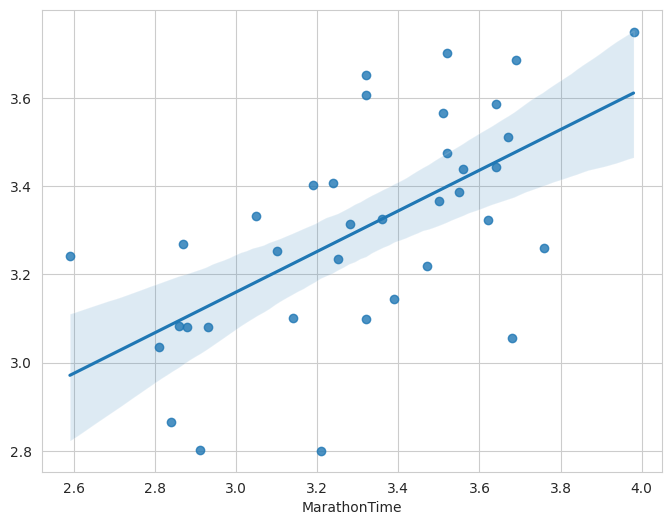

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.35,0.33,0.07,0.26,0.21


In [68]:
lasso = Lasso()
lasso_log = cross_validation(lasso)
scores_df.loc[2] = ["Lasso", lasso_log["R2"].mean(), lasso_log["Adjusted R2"].mean(), 
                lasso_log["MSE"].mean(), lasso_log["RMSE"].mean(), lasso_log["MAE"].mean()]
lasso_log

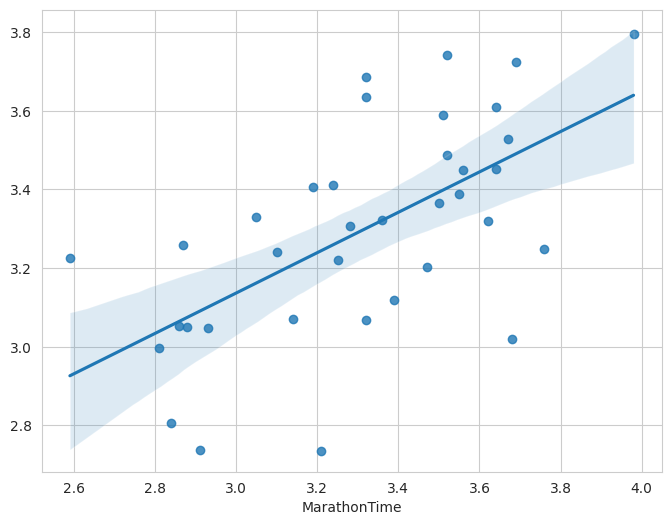

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.32,0.29,0.07,0.27,0.21


In [69]:
elastic = ElasticNet()
elastic_log = cross_validation(elastic)
scores_df.loc[3] = ["ElasticNet", elastic_log["R2"].mean(), elastic_log["Adjusted R2"].mean(), 
                elastic_log["MSE"].mean(), elastic_log["RMSE"].mean(), elastic_log["MAE"].mean()]
elastic_log

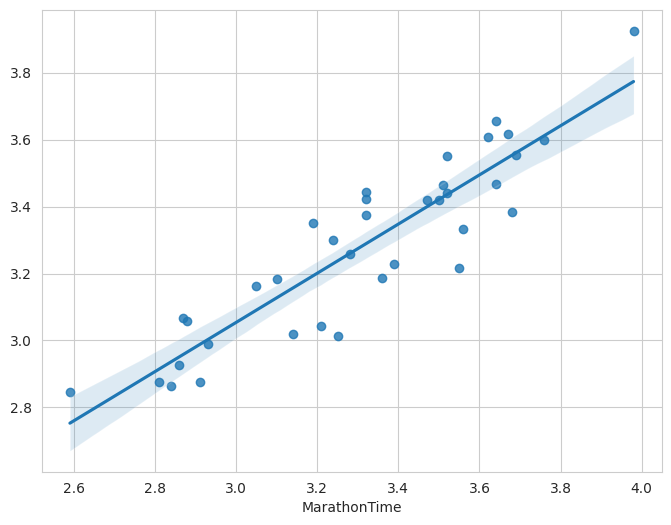

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.80,0.79,0.02,0.14,0.12


In [70]:
kernel = KernelRidge()
kernel_log = cross_validation(kernel)
scores_df.loc[4] = ["KernelRidge", kernel_log["R2"].mean(), kernel_log["Adjusted R2"].mean(), 
                kernel_log["MSE"].mean(), kernel_log["RMSE"].mean(), kernel_log["MAE"].mean()]
kernel_log

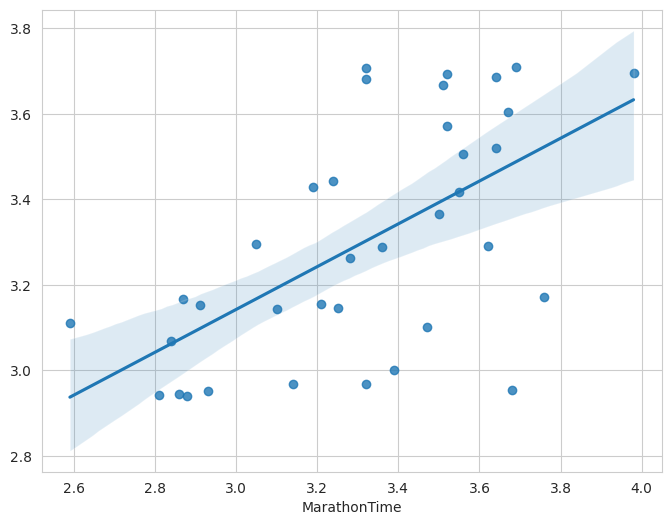

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.31,0.28,0.07,0.27,0.21


In [71]:
svr = SVR()
svr_log = cross_validation(svr)
scores_df.loc[5] = ["SVR", svr_log["R2"].mean(), svr_log["Adjusted R2"].mean(), 
                svr_log["MSE"].mean(), svr_log["RMSE"].mean(), svr_log["MAE"].mean()]
svr_log

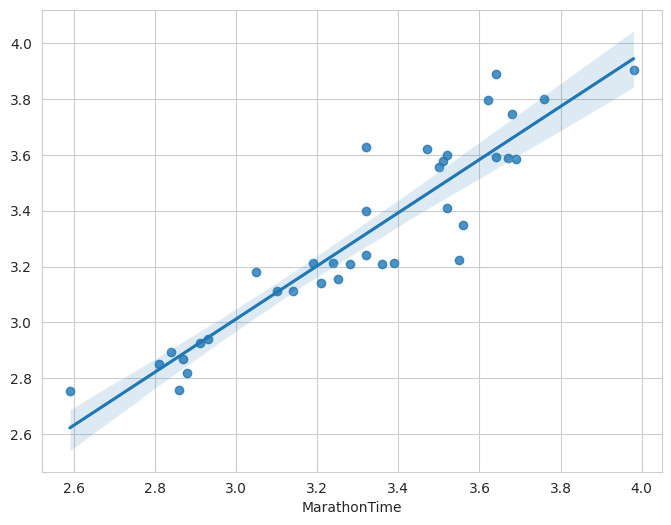

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.85,0.84,0.02,0.13,0.10


In [72]:
rf = RandomForestRegressor()
rf_log = cross_validation(rf)
scores_df.loc[6] = ["RandomForestRegressor", rf_log["R2"].mean(), rf_log["Adjusted R2"].mean(), 
                rf_log["MSE"].mean(), rf_log["RMSE"].mean(), rf_log["MAE"].mean()]
rf_log

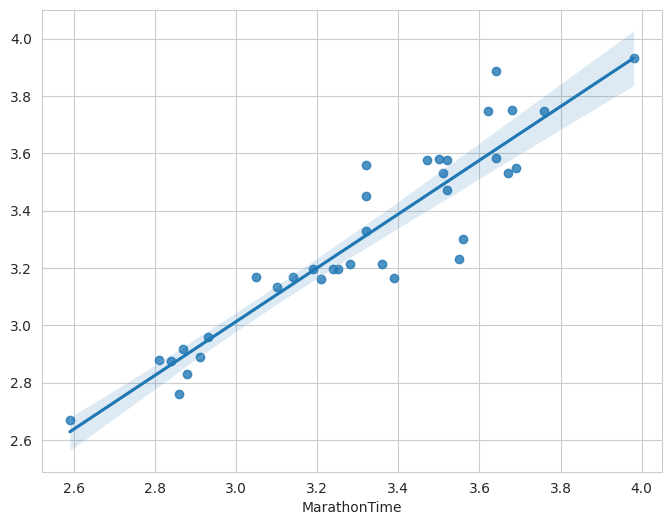

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.86,0.85,0.01,0.12,0.09


In [73]:
gbr = GradientBoostingRegressor()
gbr_log = cross_validation(gbr)
scores_df.loc[7] = ["GradientBoostingRegressor", gbr_log["R2"].mean(), gbr_log["Adjusted R2"].mean(), 
                gbr_log["MSE"].mean(), gbr_log["RMSE"].mean(), gbr_log["MAE"].mean()]
gbr_log

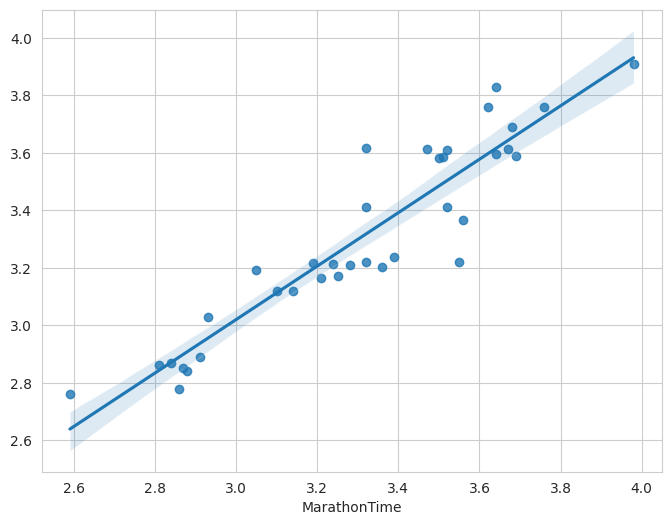

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.86,0.86,0.01,0.12,0.09


In [74]:
ada = AdaBoostRegressor()
ada_log = cross_validation(ada)
scores_df.loc[8] = ["AdaBoostRegressor", ada_log["R2"].mean(), ada_log["Adjusted R2"].mean(), 
                ada_log["MSE"].mean(), ada_log["RMSE"].mean(), ada_log["MAE"].mean()]
ada_log

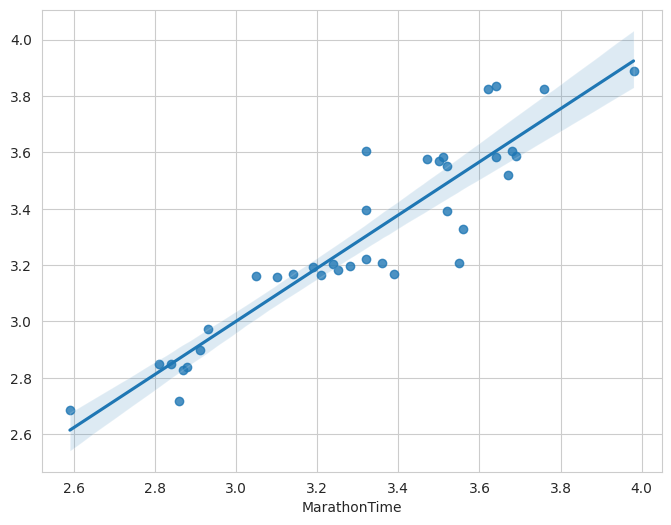

,R2,Adjusted R2,MSE,RMSE,MAE
0,0.84,0.84,0.02,0.13,0.10


In [75]:
xgb = XGBRegressor()
xgb_log = cross_validation(xgb)
scores_df.loc[9] = ["XGBRegressor", xgb_log["R2"].mean(), xgb_log["Adjusted R2"].mean(), 
                xgb_log["MSE"].mean(), xgb_log["RMSE"].mean(), xgb_log["MAE"].mean()]
xgb_log

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 0
[LightGBM] [Info] Start training from score 3.363143
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM

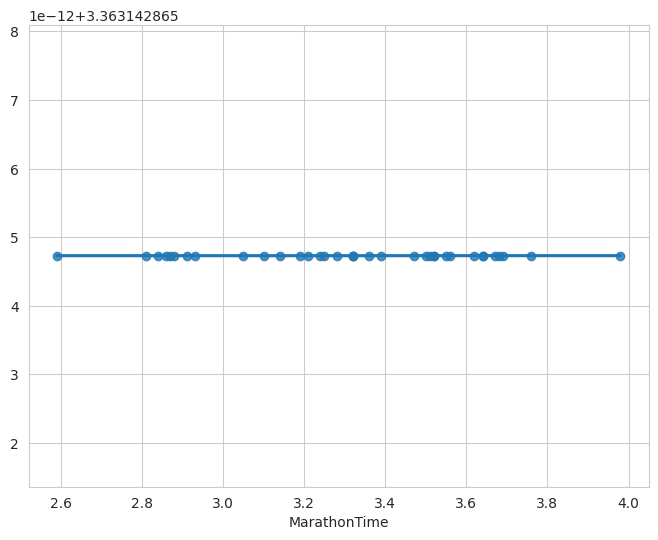

,R2,Adjusted R2,MSE,RMSE,MAE
0,-0.03,-0.07,0.11,0.33,0.27


In [76]:
lgbm = LGBMRegressor()
lgbm_log = cross_validation(lgbm)
scores_df.loc[10] = ["LGBMRegressor", lgbm_log["R2"].mean(), lgbm_log["Adjusted R2"].mean(), 
                lgbm_log["MSE"].mean(), lgbm_log["RMSE"].mean(), lgbm_log["MAE"].mean()]
lgbm_log

# Results

In [77]:
scores_df

,Model,R2,Adjusted R2,MSE,RMSE,MAE
0,LinearRegression,0.91,0.91,0.01,0.10,0.08
1,Ridge,0.80,0.79,0.02,0.14,0.11
2,Lasso,0.35,0.33,0.07,0.26,0.21
3,ElasticNet,0.32,0.29,0.07,0.27,0.21
4,KernelRidge,0.80,0.79,0.02,0.14,0.12
5,SVR,0.31,0.28,0.07,0.27,0.21
6,RandomForestRegressor,0.85,0.84,0.02,0.13,0.10
7,GradientBoostingRegressor,0.86,0.85,0.01,0.12,0.09
8,AdaBoostRegressor,0.86,0.86,0.01,0.12,0.09
9,XGBRegressor,0.84,0.84,0.02,0.13,0.10


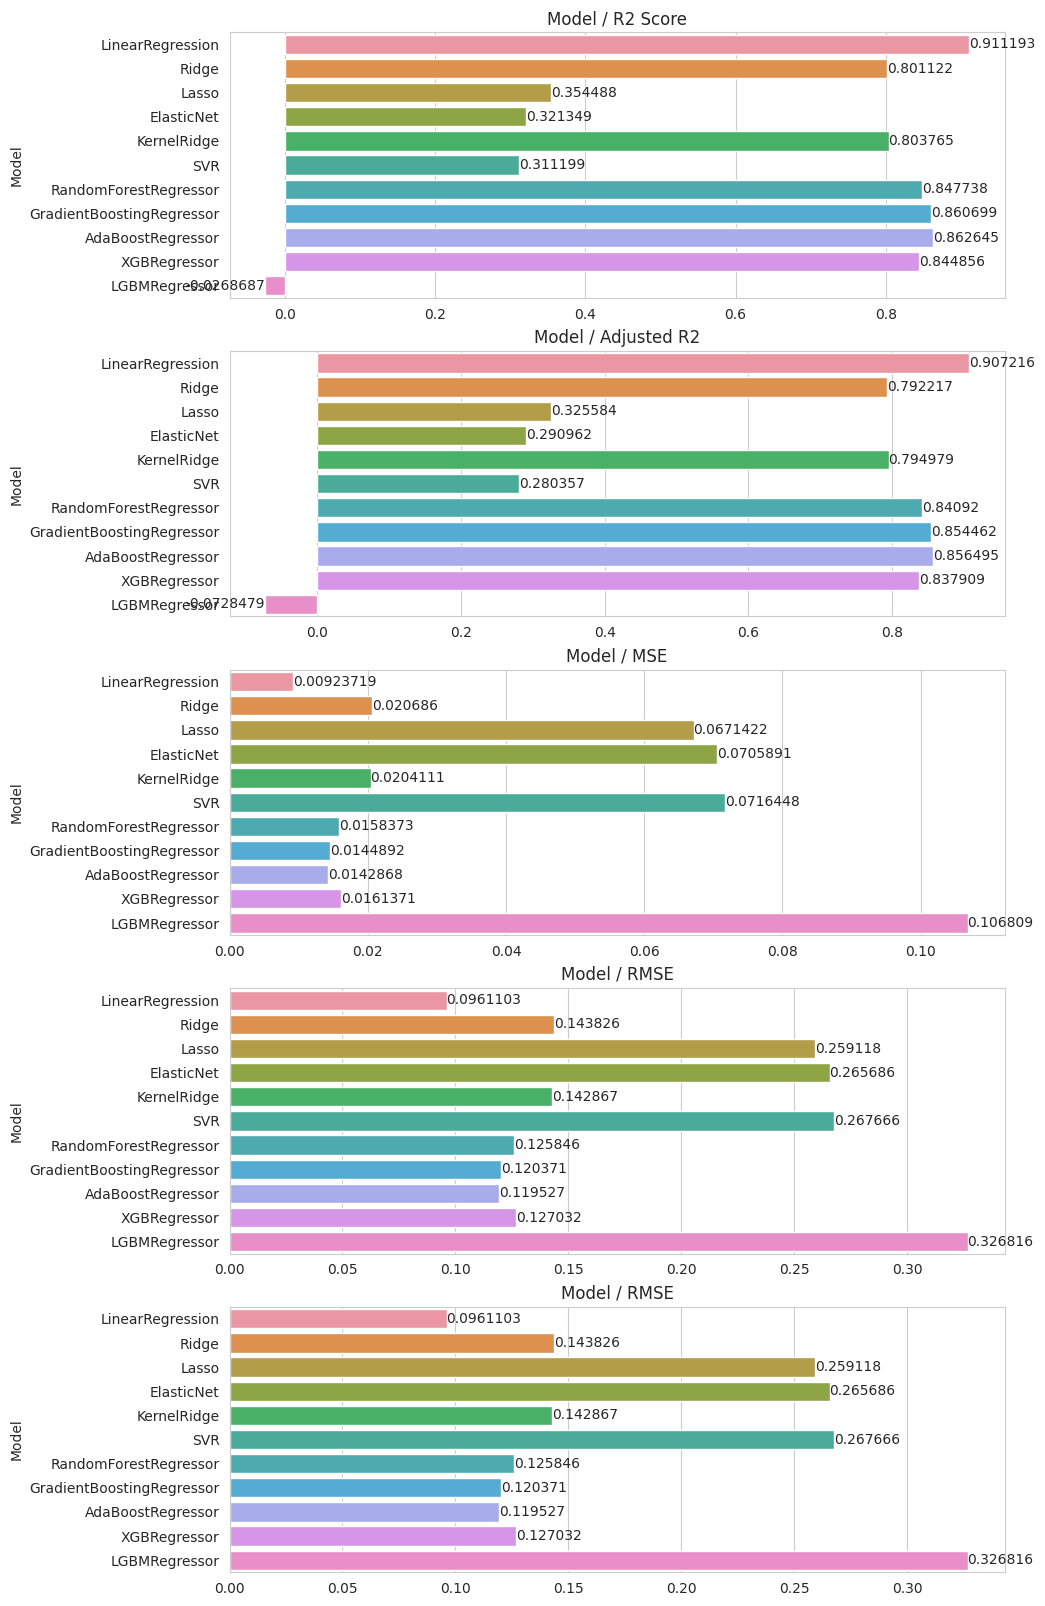

In [78]:
plt.figure(figsize=(10, 20))

plt.subplot(511)
ax = sns.barplot(data=scores_df, y="Model", x="R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / R2 Score")
plt.xlabel("")

plt.subplot(512)
ax = sns.barplot(data=scores_df, y="Model", x="Adjusted R2")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / Adjusted R2")
plt.xlabel("")

plt.subplot(513)
ax = sns.barplot(data=scores_df, y="Model", x="MSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / MSE")
plt.xlabel("")

plt.subplot(514)
ax = sns.barplot(data=scores_df, y="Model", x="RMSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / RMSE")
plt.xlabel("")

plt.subplot(515)
ax = sns.barplot(data=scores_df, y="Model", x="RMSE")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Model / RMSE")
plt.xlabel("")

plt.show()